In [16]:
import math
import os
import sys
sys.path.insert(0,'..')
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from src.utilities import DataHandler, FileHandler

# KPIs
---

In [2]:
evaluation_data = DataHandler.get_concat_data('reward_tuning', 'evaluation')
evaluation_data['lower_exponent'] = evaluation_data['reward_function_kwargs'].map(lambda x: x['lower_exponent'] if x is not None else None)
evaluation_data['higher_exponent'] = evaluation_data['reward_function_kwargs'].map(lambda x: x['higher_exponent'] if x is not None else None)
evaluation_data.loc[(~evaluation_data['id'].str.contains('building_all')), 'central_agent'] = 'Decentralized'
evaluation_data = evaluation_data[(evaluation_data['higher_exponent'] <= evaluation_data['lower_exponent'] + 1.0)].copy()
evaluation_data.head()

environment  annual_normalized_unserved_energy_total  annual_peak_average  \
0      425540                                      0.0                  NaN   
1    District                                      0.0             1.063942   
2      245723                                      0.0                  NaN   
3    District                                      0.0             0.926745   
4      376570                                      0.0                  NaN   

  carbon_emissions_total  cost_total  daily_one_minus_load_factor_average  \
0                   None    1.060010                                  NaN   
1                   None    1.060010                             1.006526   
2                   None    0.957970                                  NaN   
3                   None    0.957970                             1.041029   
4                   None    0.885768                                  NaN   

   daily_peak_average  discomfort_delta_average  discomfort_delta_maximum  \
0                 NaN                 -0.255546                  2.736452   
1            1.059307                 -0.255546                  2.736452   
2                 NaN                 -0.142604                  3.156841   
3            0.983878                 -0.142604                  3.156841   
4                 NaN                 -0.524156                  1.138500   

   discomfort_delta_minimum  ...  year            library  agent  rbc_name  \
0                 -6.111827  ...     3  stable-baselines3    SAC     NoRBC   
1                 -6.111827  ...     3  stable-baselines3    SAC     NoRBC   
2                 -3.500175  ...     5  stable-baselines3    SAC     NoRBC   
3                 -3.500175  ...     5  stable-baselines3    SAC     NoRBC   
4                 -4.282873  ...     4  stable-baselines3    SAC     NoRBC   

   random_seed  central_agent reward_function_name  \
0            0  Decentralized        ComfortReward   
1            0  Decentralized        ComfortReward   
2            0  Decentralized        ComfortReward   
3            0  Decentralized        ComfortReward   
4            0  Decentralized        ComfortReward   

                            reward_function_kwargs  lower_exponent  \
0  {'lower_exponent': 1.4, 'higher_exponent': 1.4}             1.4   
1  {'lower_exponent': 1.4, 'higher_exponent': 1.4}             1.4   
2  {'lower_exponent': 1.8, 'higher_exponent': 1.8}             1.8   
3  {'lower_exponent': 1.8, 'higher_exponent': 1.8}             1.8   
4  {'lower_exponent': 1.6, 'higher_exponent': 1.6}             1.6   

  higher_exponent  
0             1.4  
1             1.4  
2             1.8  
3             1.8  
4             1.6  

[5 rows x 31 columns]

## Comparison between centralized and decentralized agents building-level discomfort hours

In [17]:
# cmap = 'coolwarm'
# column = 'discomfort_proportion'
# plot_data = evaluation_data[(evaluation_data['environment']!='District')].copy()
# column_count = 2
# row_count = 1

# for b, bdata in plot_data.groupby('environment'):
#     fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count, 3.5), sharey=True)
#     vmin = bdata[column].min()
#     vmax = bdata[column].max()
#     vcenter = vmin + (vmax - vmin)/2.0
#     print(b, vmin, vmax, vcenter)

#     if vmin != vmax:
#         divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    
#     else:
#         divnorm = colors.TwoSlopeNorm(vcenter=vcenter)

#     for i, (ax, (central_agent, cdata)) in enumerate(zip(fig.axes, bdata.groupby('central_agent'))):
#         plot_data = cdata.pivot(index='higher_exponent', columns='lower_exponent', values=column)
#         x, y, z = plot_data.columns, plot_data.index, plot_data.values
#         pcm = ax.pcolormesh(x, y, z, shading='nearest', cmap=cmap, norm=divnorm, edgecolors='black', linewidth=0.1)
#         ax.set_xlabel('Lower exponent')

#         if i == 0:
#             ax.set_ylabel('Higher exponent')
#         else:
#             pass

#         ax.set_xticks(x)
#         ax.set_yticks(y)
#         ax.set_title(central_agent)

#         for (j, k), z in np.ndenumerate(plot_data):
#             color = 'black' if 0.7 <= z <= 1.4 else 'white'
#             ax.text(x[k], y[j], f'{z:0.3f}', ha='center', va='center', color=color)

#         cb = fig.colorbar(pcm, ax=ax, orientation='horizontal', label=None, fraction=0.05, pad=0.2)

#     fig.suptitle(f'Building {b}')
#     plt.tight_layout()
#     plt.show()

- Decentralized control provides better building-level comfort.
- Increasing delta between lower and higher exponents worsens comfort.
- Each building should have a decentralized controller with unique exponents to maximize comfort performance.

## Comparison of discomfort, electricity consumption and peak when reward exponents are varied for decentralized control

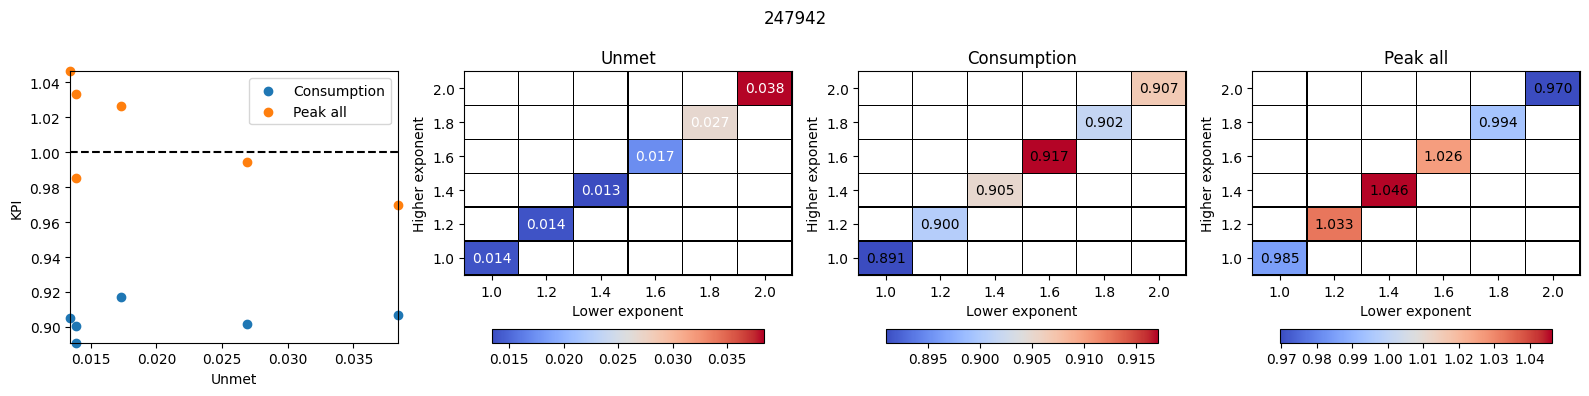

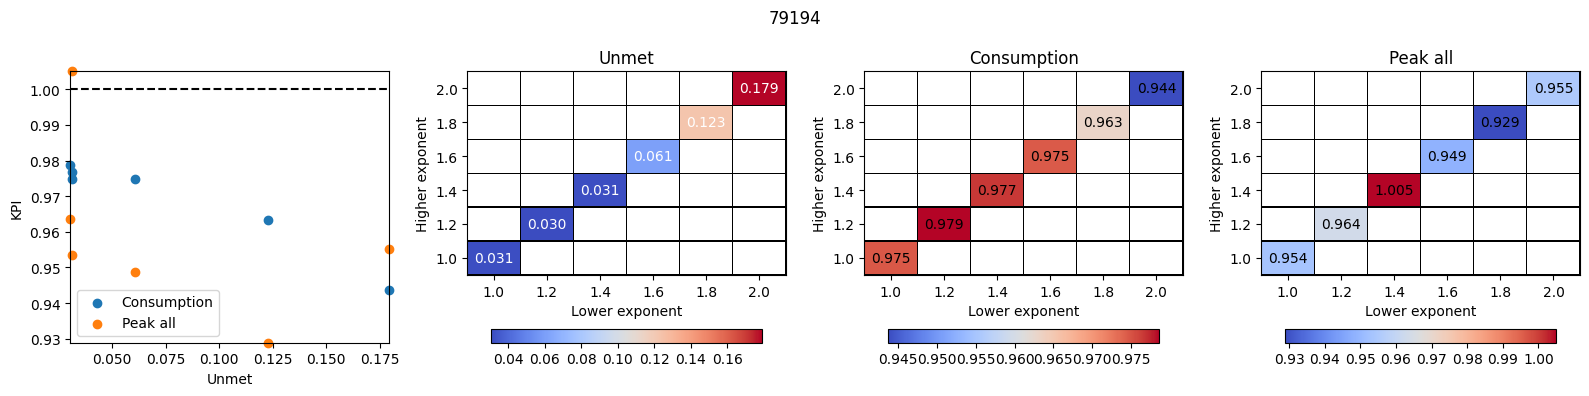

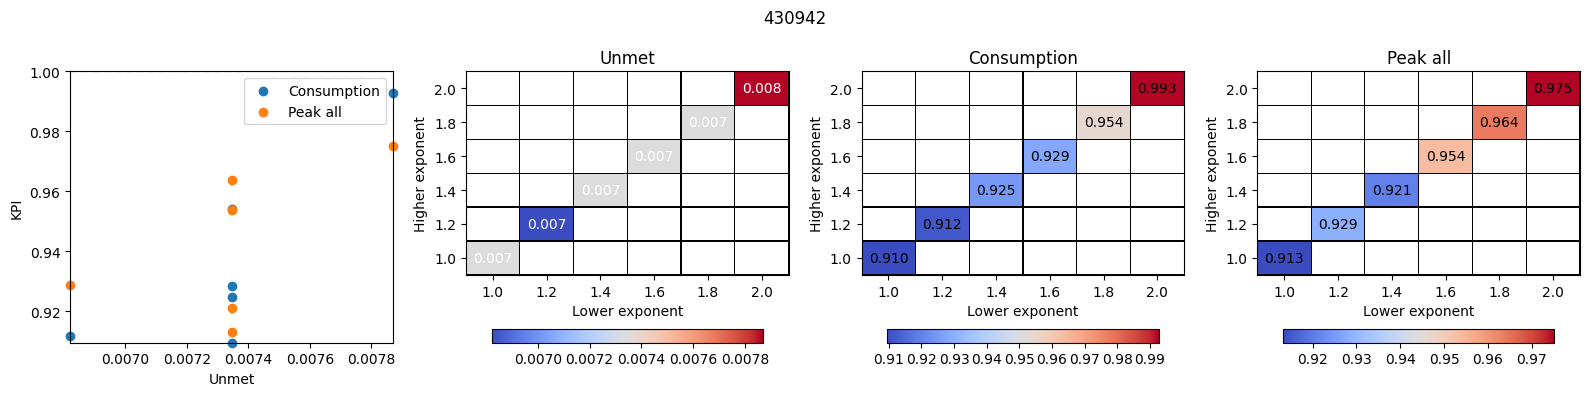

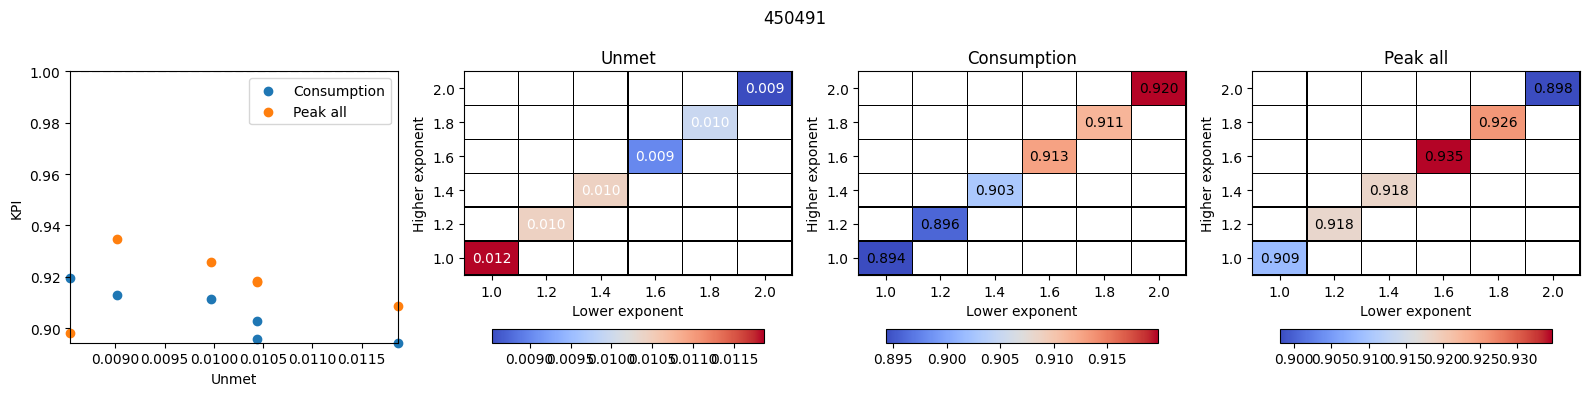

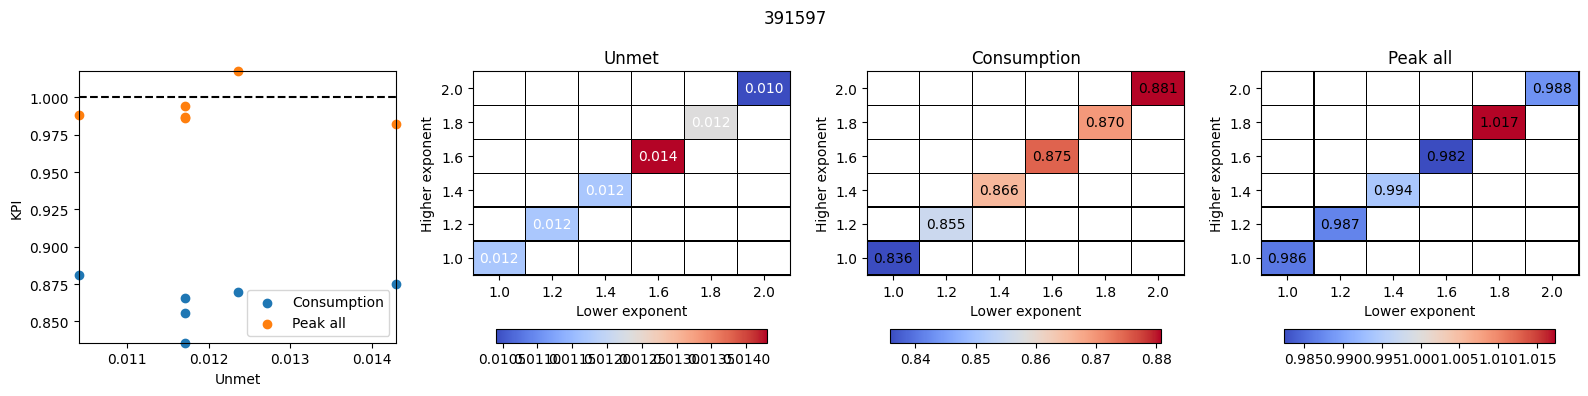

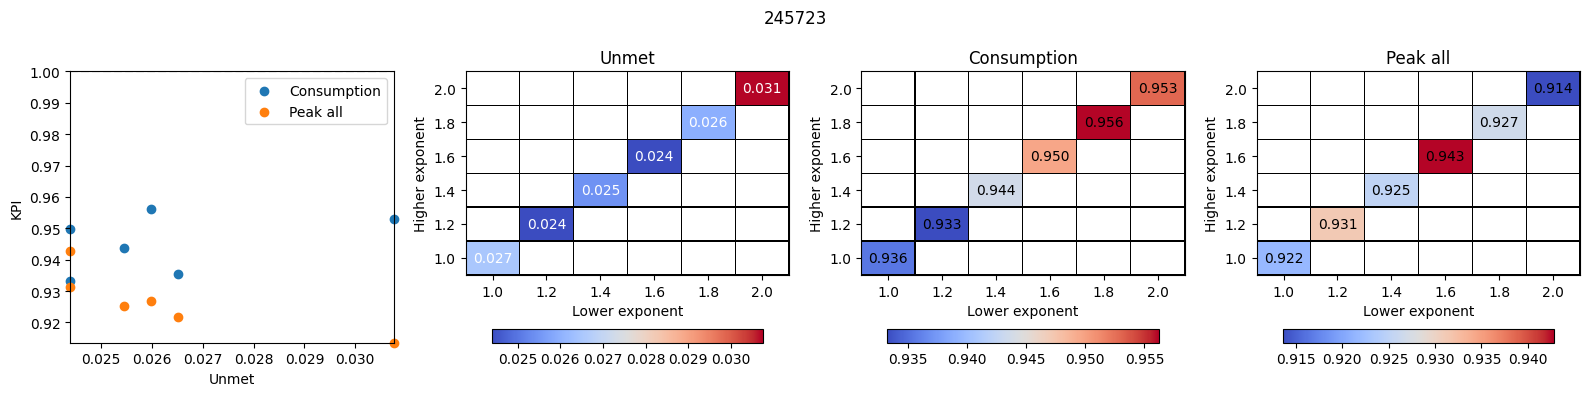

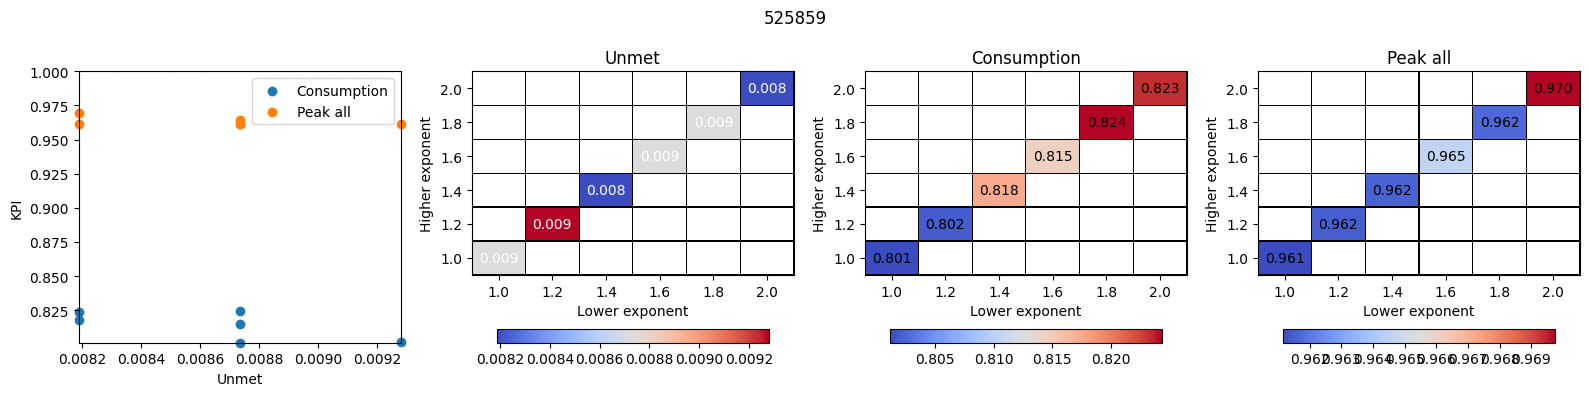

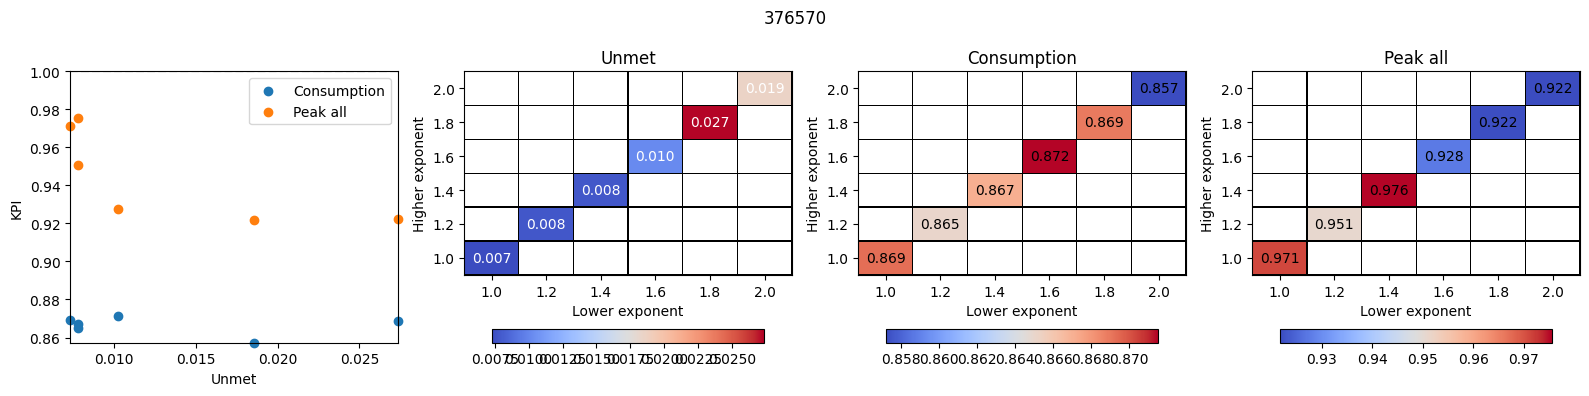

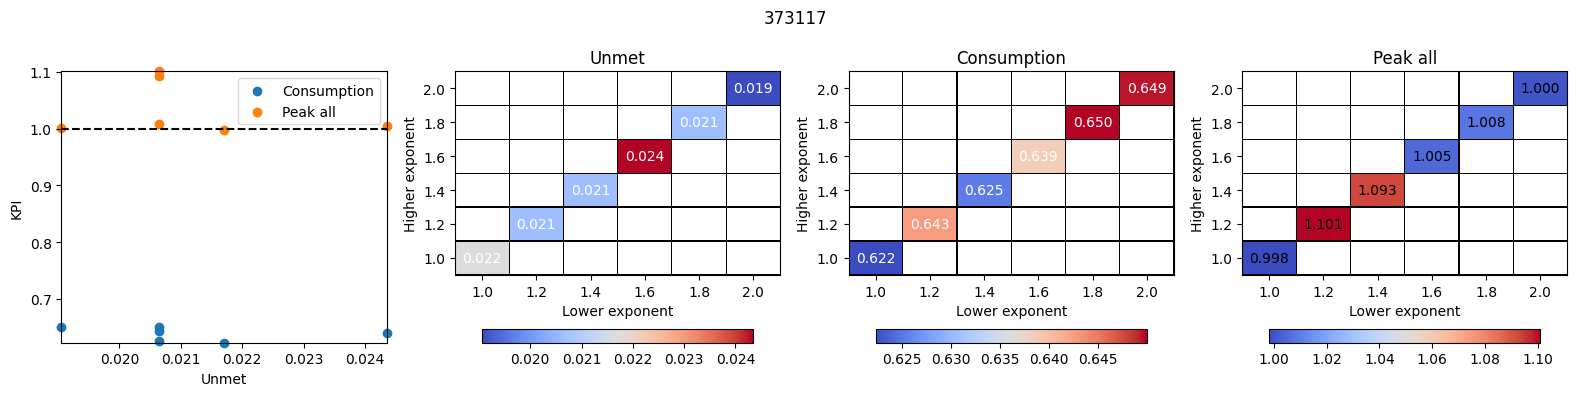

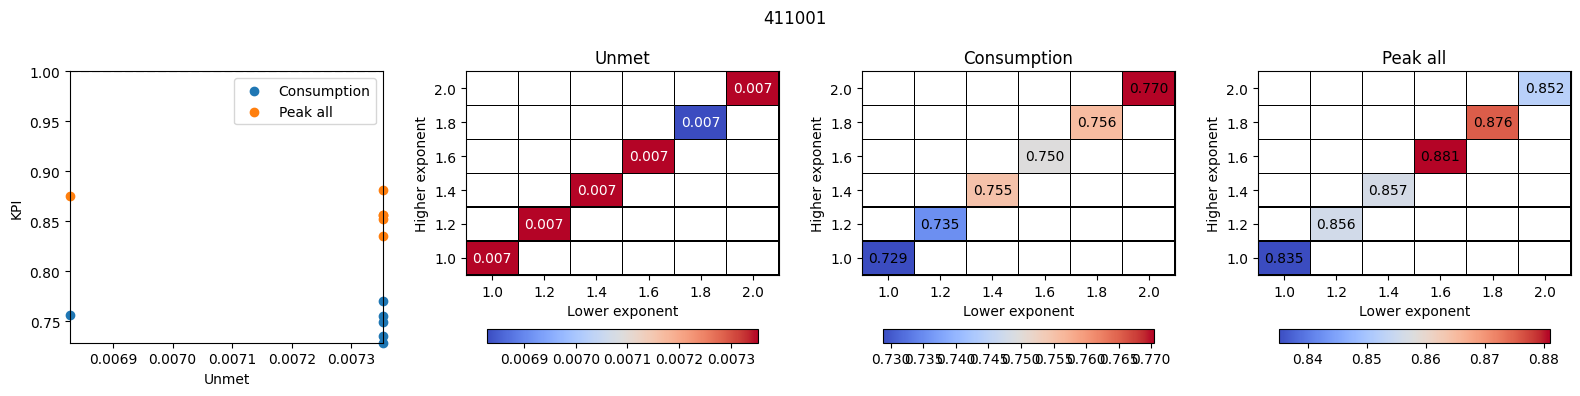

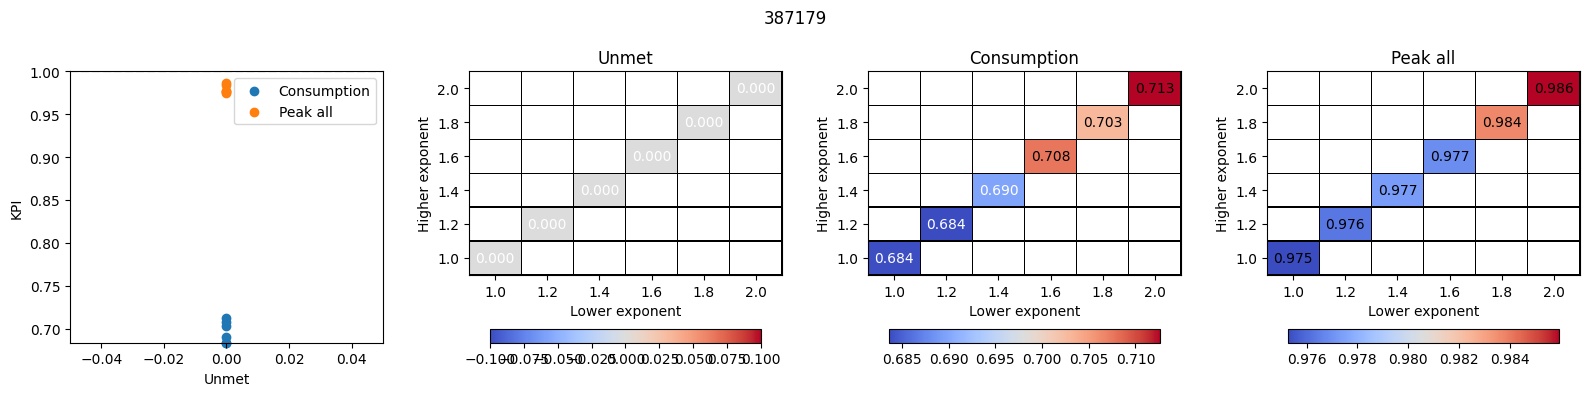

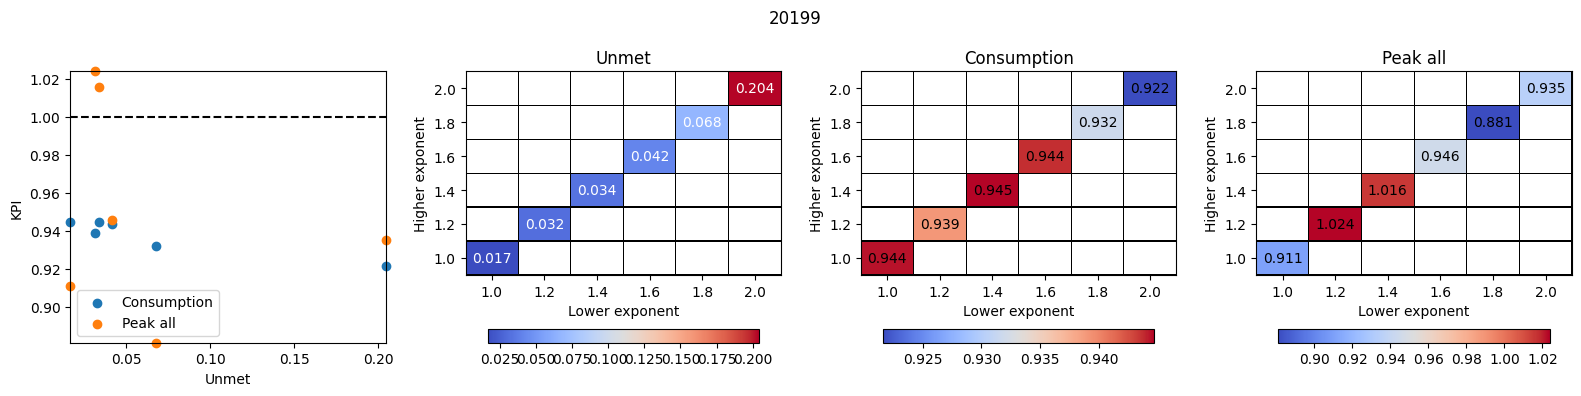

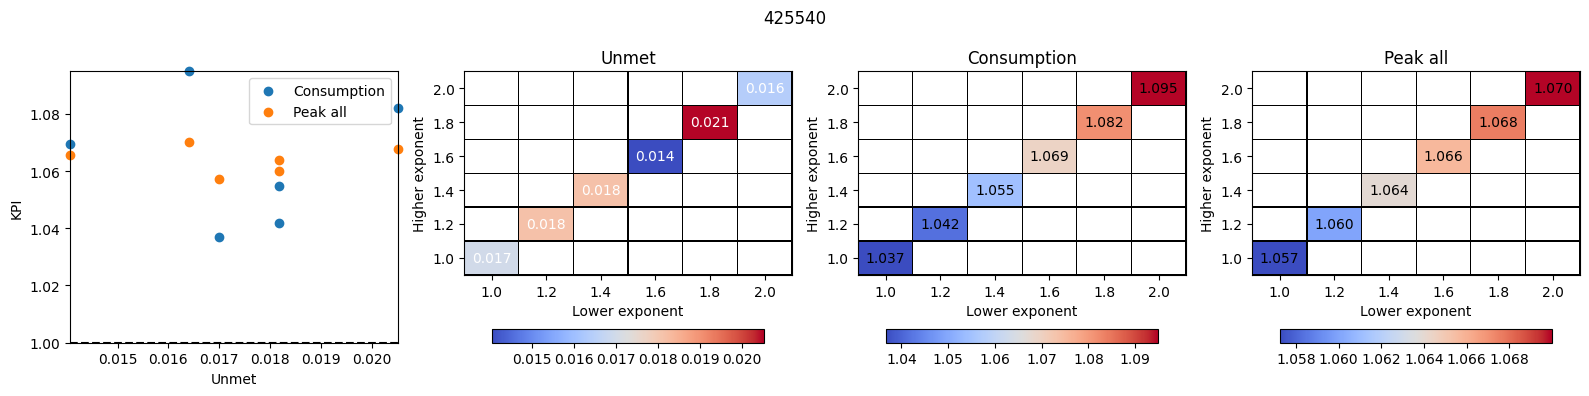

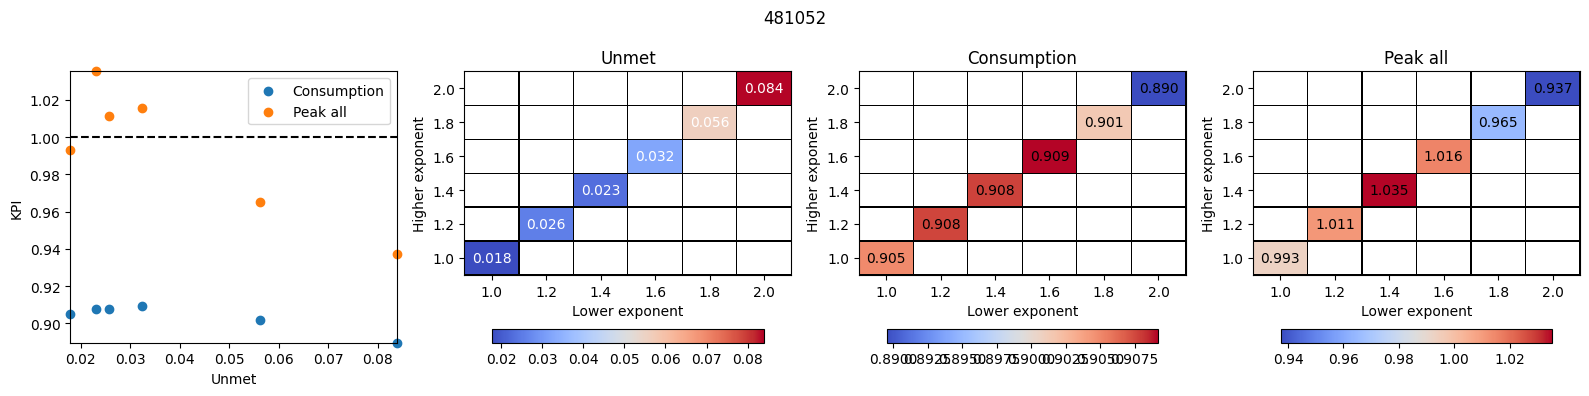

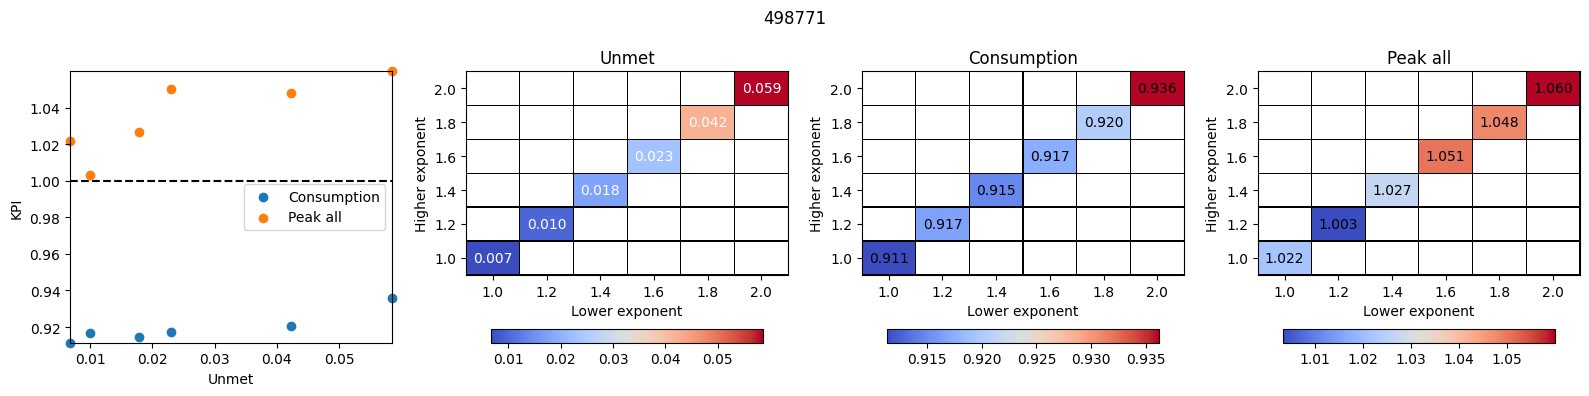

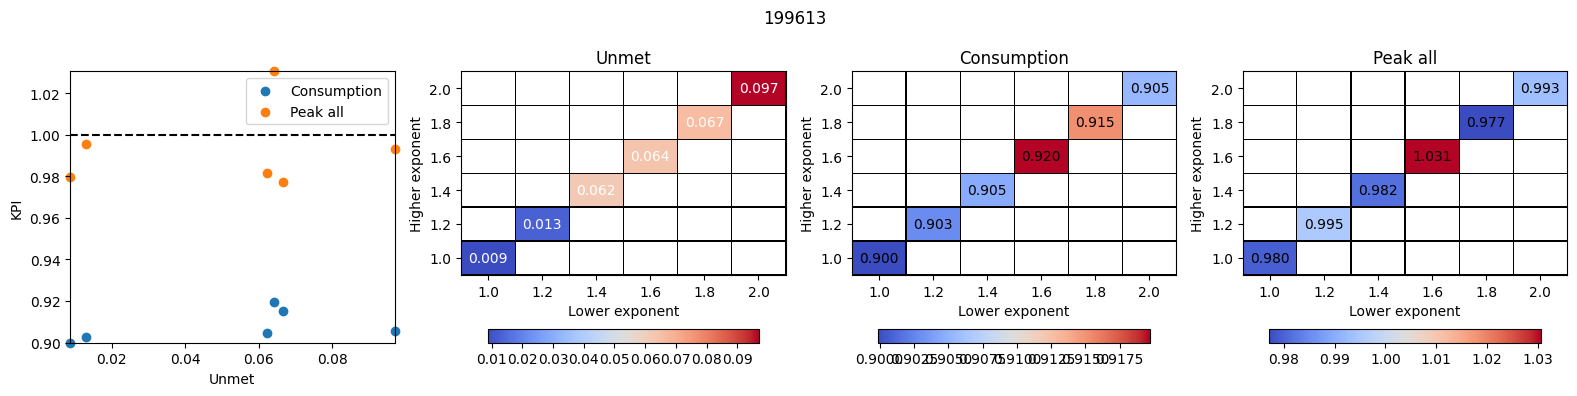

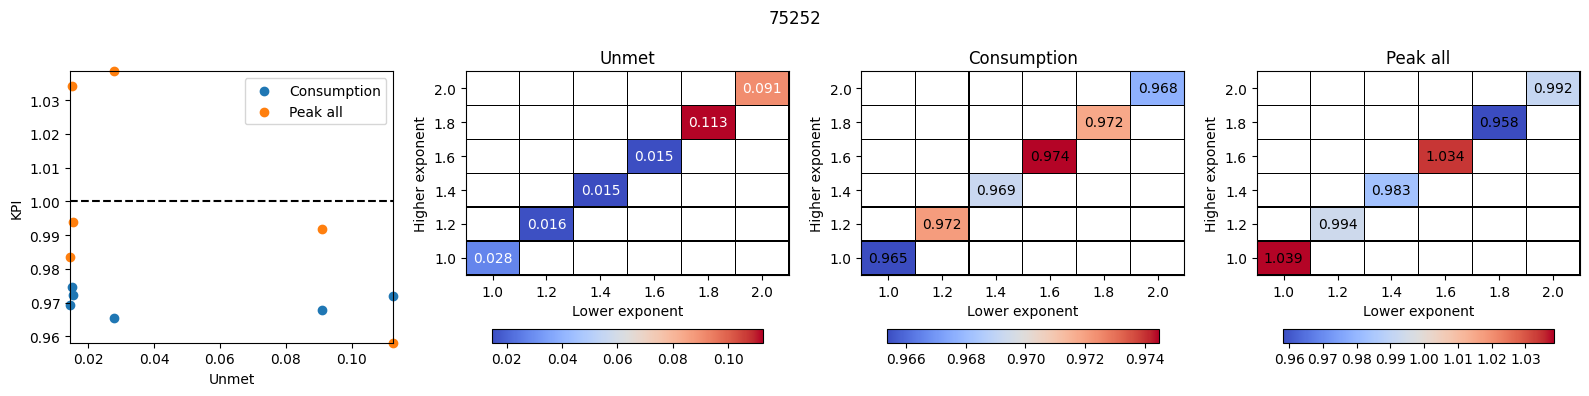

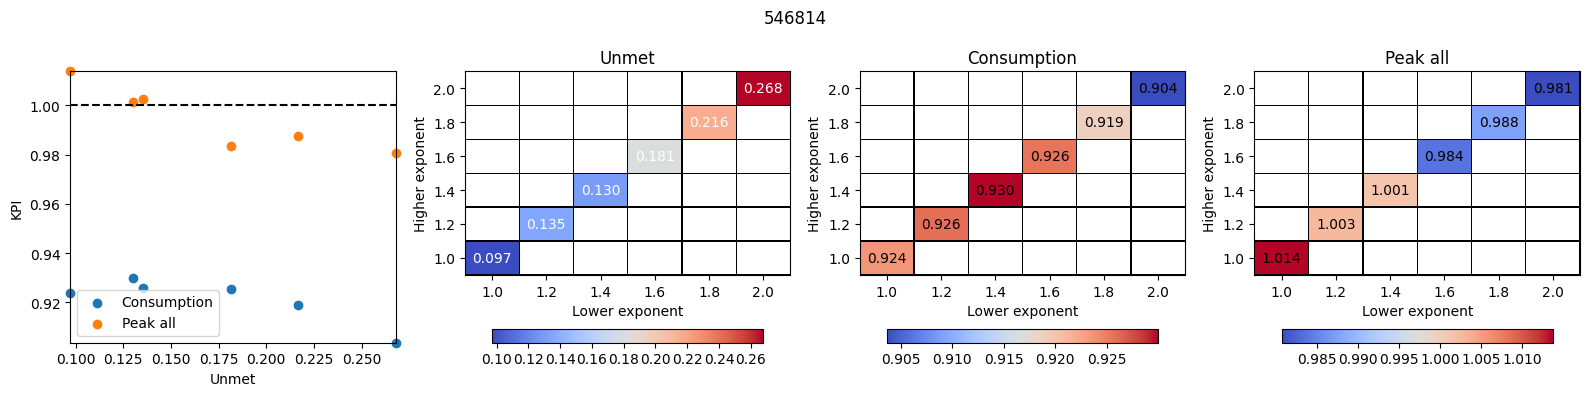

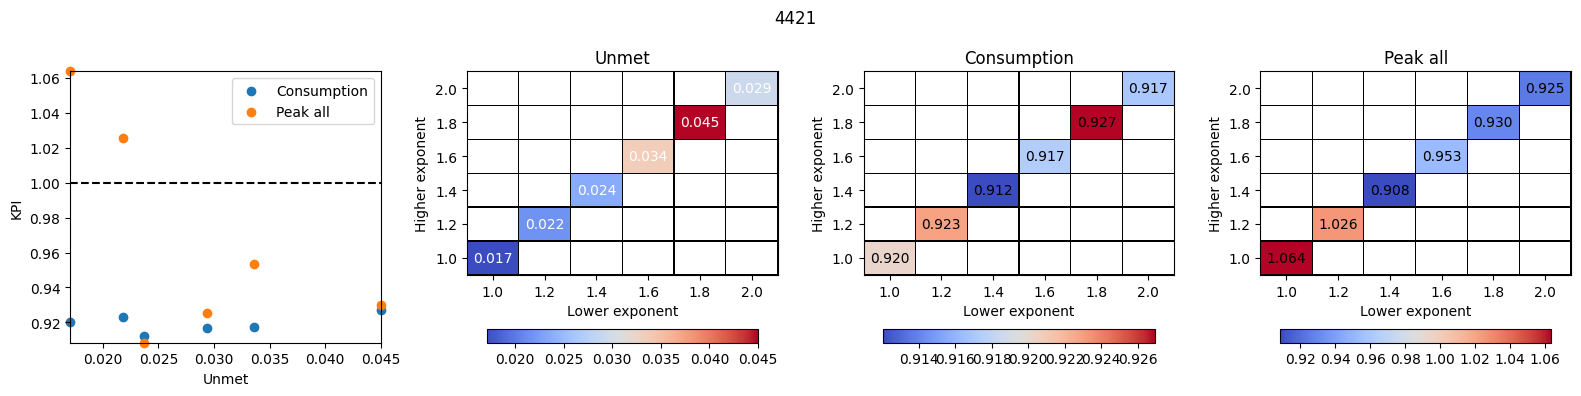

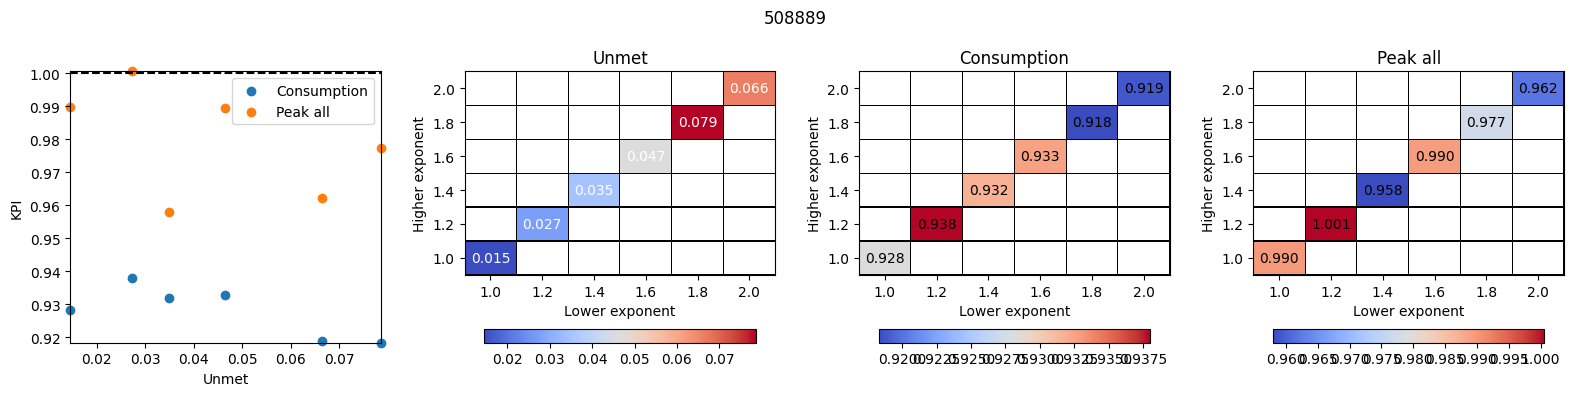

In [7]:
cmap = 'coolwarm'
columns = [
    'discomfort_proportion',
    'electricity_consumption_total',
    'annual_peak_average',
    # 'daily_one_minus_load_factor_average',
    # 'daily_peak_average',
    # 'ramping_average',
]
column_count_limit = 5
row_count = math.ceil((len(columns) + 1)/column_count_limit)
column_count = min(len(columns) + 1, column_count_limit)
plot_data = evaluation_data[(evaluation_data['central_agent']=='Decentralized')].copy()
plot_data['building_name'] = plot_data['id'].str.split('-', expand=True)[6]

for _, bdata in plot_data.groupby('building_name'):
    b = bdata[(bdata['environment']!='District')]['environment'].iloc[0]
    bdata = bdata[(bdata['environment']=='District')].copy()
    fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count, 4*row_count),)

    # scatter plot
    x = bdata[columns[0]].tolist()

    for c in columns[1:]:
        y = bdata[c].tolist()
        fig.axes[0].scatter(x, y, clip_on=False, label=DataHandler.KPI_LABELS[c])

    fig.axes[0].axhline(1.0, color='black', linestyle='--')
    fig.axes[0].set_xlabel(DataHandler.KPI_LABELS[columns[0]])
    fig.axes[0].set_ylabel('KPI')
    fig.axes[0].margins(0)
    fig.axes[0].legend()

    for ax in fig.axes[len(columns) + 1:]:
        fig.delaxes(ax)

    for i, (ax, c) in enumerate(zip(fig.axes[1:], columns)):
        vmin = bdata[c].min()
        vmax = bdata[c].max()
        vcenter = vmin + (vmax - vmin)/2.0

        if vmin != vmax:
            divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
            
        else:
            divnorm = colors.TwoSlopeNorm(vcenter=vcenter)

        plot_data = bdata.pivot(index='higher_exponent', columns='lower_exponent', values=c)
        x, y, z = plot_data.columns, plot_data.index, plot_data.values
        pcm = ax.pcolormesh(x, y, z, shading='nearest', cmap=cmap, norm=divnorm, edgecolors='black', linewidth=0.1)
        ax.set_xlabel('Lower exponent')
        ax.set_ylabel('Higher exponent')
        ax.set_xticks(x)
        ax.set_yticks(y)
        ax.set_title(DataHandler.KPI_LABELS[c])

        for (j, k), z in np.ndenumerate(plot_data):
            color = 'black' if 0.7 <= z <= 1.4 else 'white'
            ax.text(x[k], y[j], f'{z:0.3f}', ha='center', va='center', color=color)

        cb = fig.colorbar(pcm, ax=ax, orientation='horizontal', label=None, fraction=0.05, pad=0.2)

    fig.suptitle(f'{b}')
    plt.tight_layout()
    plt.show()

- Discomfort is inversely related to electricity consumption and peak.
- All exponent combinations is all buildings but 247942 result in reduced electricity consumption compared to the baseline.
- For the majority, peak is reduced.
- Will pick combination that minimizes discomfort in each building

In [20]:
plot_data = evaluation_data[
    (evaluation_data['central_agent']=='Decentralized')
    & (evaluation_data['environment']!='District')
].copy()
plot_data['building_name'] = plot_data['id'].str.split('-', expand=True)[6]
plot_data['building_index'] = plot_data['building_name'].str.split('_', expand=True)[1].astype(int) - 1
plot_data['minimum_discomfort_proportion'] = plot_data.groupby(['environment', 'building_index', 'building_name'])[['discomfort_proportion']].transform(min)
plot_data = plot_data[plot_data['minimum_discomfort_proportion']==plot_data['discomfort_proportion']].copy()
plot_data = plot_data[['building_index', 'building_name', 'environment', 'lower_exponent', 'higher_exponent', 'discomfort_proportion', 'id']].sort_values(['building_index', 'lower_exponent'])
plot_data = plot_data.drop_duplicates(['building_index', 'discomfort_proportion'])
display(plot_data)
plot_data.to_csv(os.path.join(FileHandler.METADATA_DIRECTORY, 'comfort_reward_tuning_best_result.csv'), index=False)

building_index building_name environment  lower_exponent  \
88                0    building_1      247942             1.4   
100               1    building_2       20199             1.0   
140               2    building_3      481052             1.0   
164               3    building_4      498771             1.0   
84                4    building_5      199613             1.0   
96                5    building_6       75252             1.4   
18                6    building_7      546814             1.0   
30                7    building_8        4421             1.0   
206               8    building_9      508889             1.0   
220               9   building_10       79194             1.2   
14               10   building_11      430942             1.2   
8                11   building_12      450491             2.0   
228              12   building_13      391597             2.0   
104              13   building_14      245723             1.2   
196              14   building_15      525859             1.4   
216              15   building_16      376570             1.0   
110              16   building_17      373117             2.0   
134              17   building_18      411001             1.8   
200              18   building_19      387179             1.0   
106              19   building_20      425540             1.6   

     higher_exponent  discomfort_proportion  \
88               1.4               0.013436   
100              1.0               0.016721   
140              1.0               0.017834   
164              1.0               0.006799   
84               1.0               0.008691   
96               1.4               0.014602   
18               1.0               0.097162   
30               1.0               0.017054   
206              1.0               0.014543   
220              1.2               0.030378   
14               1.2               0.006821   
8                2.0               0.008543   
228              2.0               0.010403   
104              1.2               0.024390   
196              1.4               0.008188   
216              1.0               0.007324   
110              2.0               0.019058   
134              1.8               0.006828   
200              1.0               0.000000   
106              1.6               0.014068   

                                                    id  
88   lod_2-stable_baselines3-sac-norbc-centralized-...  
100  lod_2-stable_baselines3-sac-norbc-centralized-...  
140  lod_2-stable_baselines3-sac-norbc-centralized-...  
164  lod_2-stable_baselines3-sac-norbc-centralized-...  
84   lod_2-stable_baselines3-sac-norbc-centralized-...  
96   lod_2-stable_baselines3-sac-norbc-centralized-...  
18   lod_2-stable_baselines3-sac-norbc-centralized-...  
30   lod_2-stable_baselines3-sac-norbc-centralized-...  
206  lod_2-stable_baselines3-sac-norbc-centralized-...  
220  lod_2-stable_baselines3-sac-norbc-centralized-...  
14   lod_2-stable_baselines3-sac-norbc-centralized-...  
8    lod_2-stable_baselines3-sac-norbc-centralized-...  
228  lod_2-stable_baselines3-sac-norbc-centralized-...  
104  lod_2-stable_baselines3-sac-norbc-centralized-...  
196  lod_2-stable_baselines3-sac-norbc-centralized-...  
216  lod_2-stable_baselines3-sac-norbc-centralized-...  
110  lod_2-stable_baselines3-sac-norbc-centralized-...  
134  lod_2-stable_baselines3-sac-norbc-centralized-...  
200  lod_2-stable_baselines3-sac-norbc-centralized-...  
106  lod_2-stable_baselines3-sac-norbc-centralized-...

# Other Sanity Checks using Building 3 (481052)

## Temperature Profiles

In [6]:
time_series_data = DataHandler.get_concat_data('building_3-reward_tuning', 'time_series')
time_series_data = time_series_data.merge(evaluation_data[['id', 'lower_exponent', 'higher_exponent']], on=['id'], how='inner')
time_series_data.head()

bldg_name  net_electricity_consumption  \
0    481052                     3.549666   
1    481052                     3.549666   
2    481052                     3.314902   
3    481052                     3.314902   
4    481052                     3.327730   

   net_electricity_consumption_without_storage  \
0                                     3.549666   
1                                     3.549666   
2                                     3.314902   
3                                     3.314902   
4                                     3.327730   

   net_electricity_consumption_without_storage_and_partial_load  \
0                                           3.549666              
1                                           3.549666              
2                                           3.314902              
3                                           3.314902              
4                                           3.327730              

   net_electricity_consumption_without_storage_and_partial_load_and_pv  \
0                                           3.549666                     
1                                           3.549666                     
2                                           3.314902                     
3                                           3.314902                     
4                                           3.327730                     

   indoor_dry_bulb_temperature  \
0                    19.544359   
1                    19.544359   
2                    19.481224   
3                    19.481224   
4                    19.438789   

   indoor_dry_bulb_temperature_without_partial_load  \
0                                         19.544359   
1                                         19.544359   
2                                         19.481224   
3                                         19.481224   
4                                         19.438789   

   indoor_dry_bulb_temperature_set_point  \
0                              18.944445   
1                              18.944445   
2                              18.944445   
3                              18.944445   
4                              18.944445   

   indoor_dry_bulb_temperature_set_point_without_control  occupant_count  ...  \
0                                          18.944445                 1.0  ...   
1                                          18.944445                 1.0  ...   
2                                          18.944445                 1.0  ...   
3                                          18.944445                 1.0  ...   
4                                          18.944445                 1.0  ...   

   environment                                                 id  \
0       481052  lod_2-stable_baselines3-sac-norbc-centralized-...   
1       481052  lod_2-stable_baselines3-sac-norbc-centralized-...   
2       481052  lod_2-stable_baselines3-sac-norbc-centralized-...   
3       481052  lod_2-stable_baselines3-sac-norbc-centralized-...   
4       481052  lod_2-stable_baselines3-sac-norbc-centralized-...   

             library  agent  rbc_name  central_agent  reward_function_name  \
0  stable-baselines3    SAC     NoRBC    Centralized         ComfortReward   
1  stable-baselines3    SAC     NoRBC    Centralized         ComfortReward   
2  stable-baselines3    SAC     NoRBC    Centralized         ComfortReward   
3  stable-baselines3    SAC     NoRBC    Centralized         ComfortReward   
4  stable-baselines3    SAC     NoRBC    Centralized         ComfortReward   

                            reward_function_kwargs  lower_exponent  \
0  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
1  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
2  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
3  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
4  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4

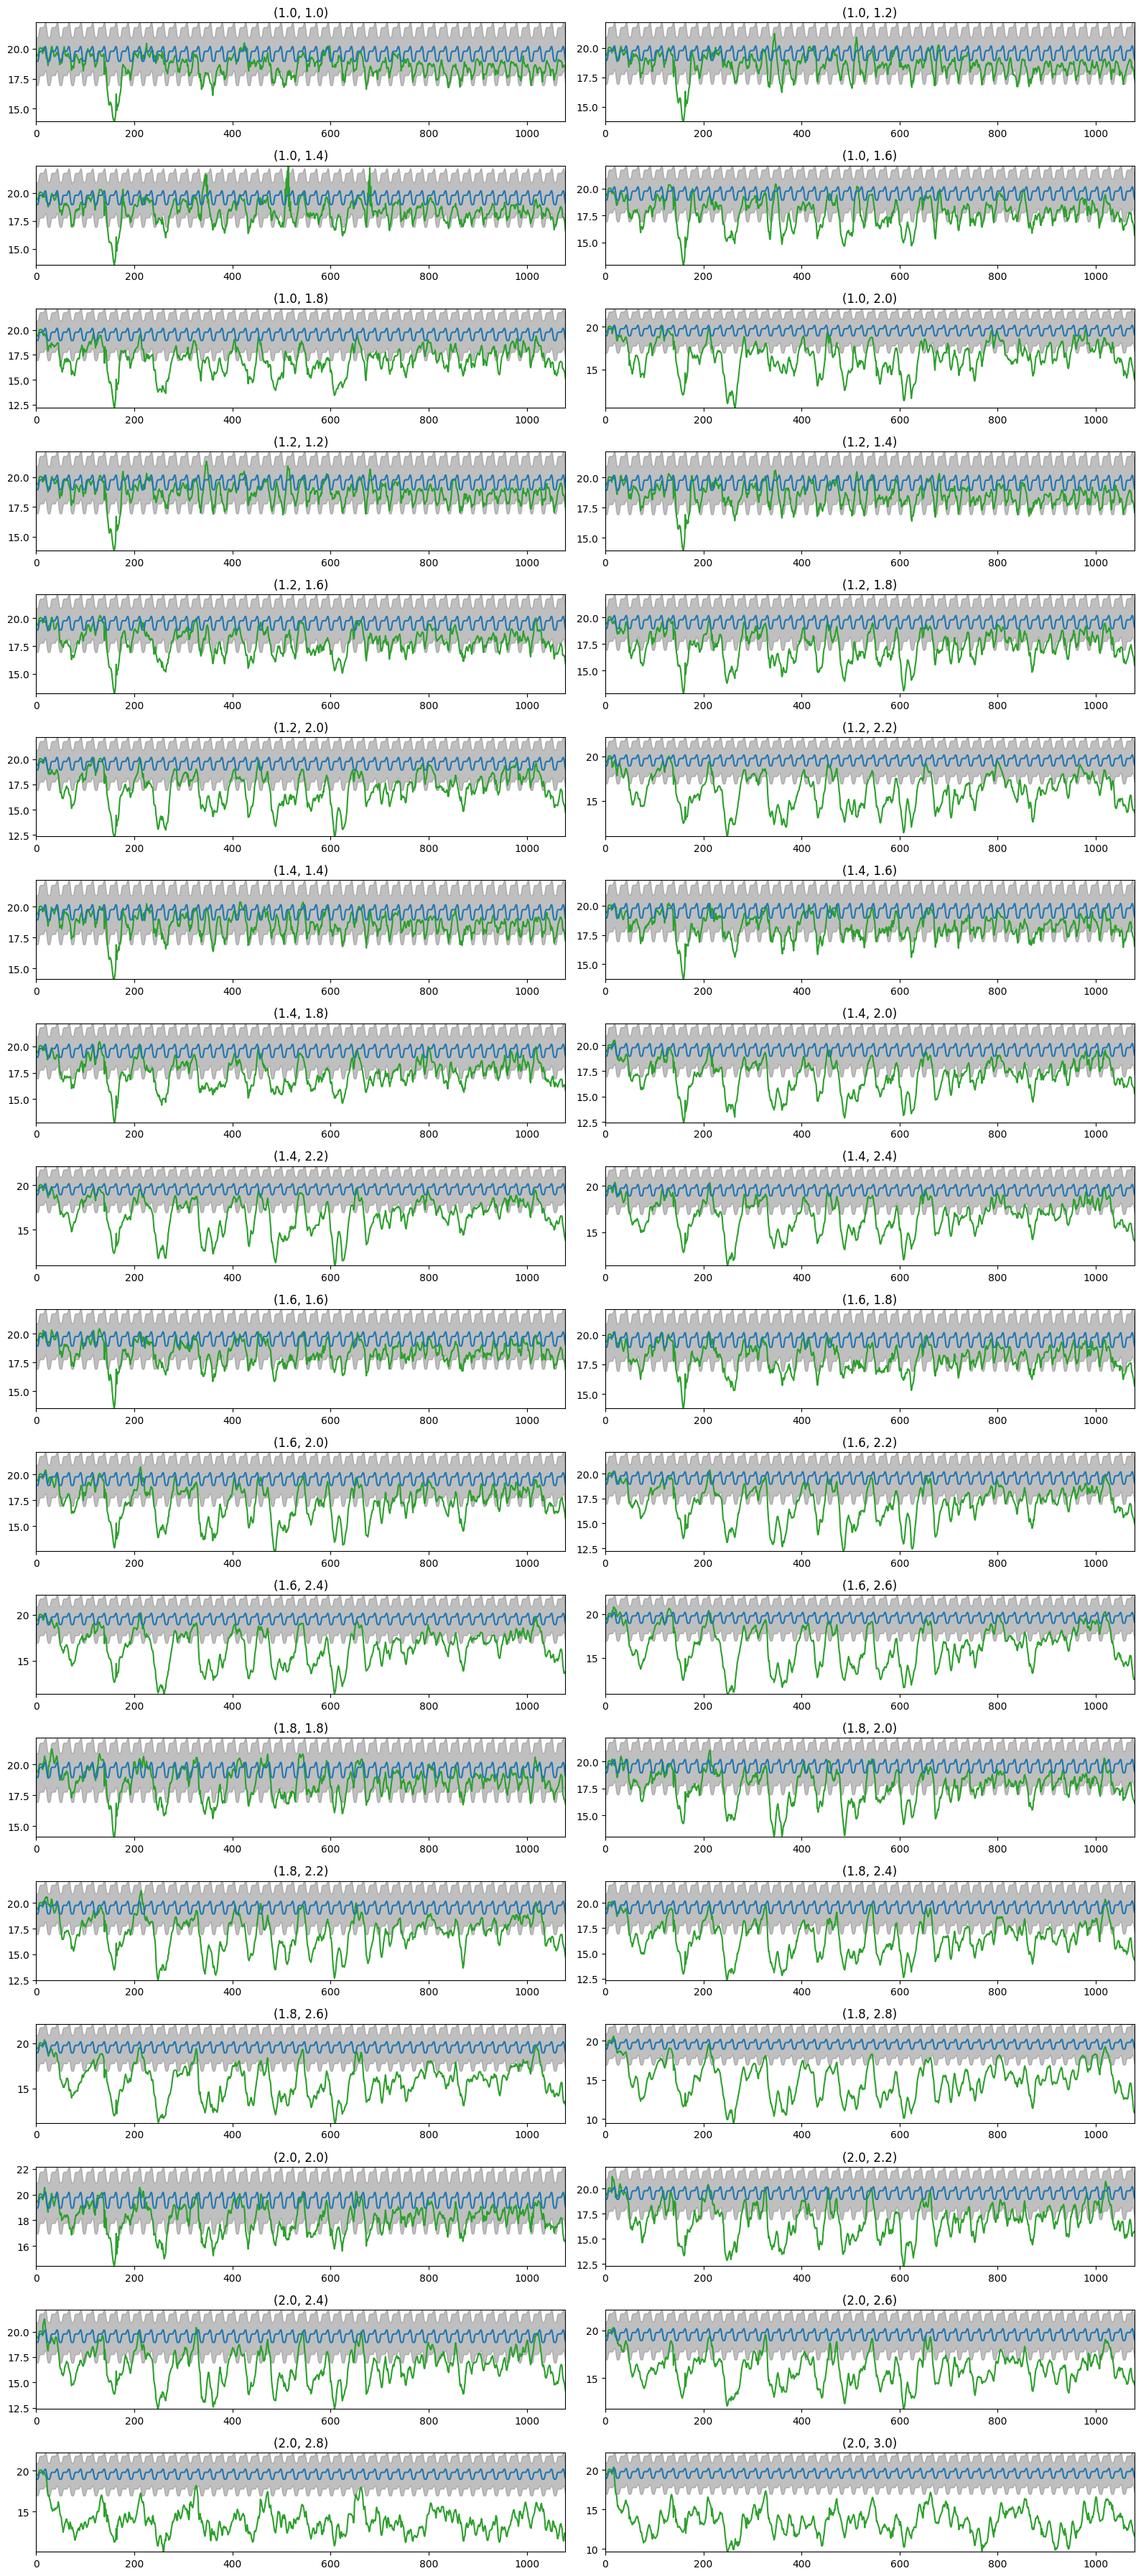

In [7]:
column_count_limit = 2
simulation_ids = time_series_data['id'].unique()
row_count = math.ceil(len(simulation_ids)/column_count_limit)
column_count = min(column_count_limit, len(simulation_ids))
fig, axs = plt.subplots(row_count, column_count, figsize=(8*column_count, 2.0*row_count))
start_ix, end_ix = 0, 2159

for ax in fig.axes[len(simulation_ids):]:
    fig.delaxes(ax)

for i, (ax, ((l, h), pdata)) in enumerate(zip(fig.axes, time_series_data.groupby(['lower_exponent', 'higher_exponent']))):
    pdata = pdata.iloc[start_ix:end_ix]
    x = pdata['time_step'].tolist()
    y = pdata['indoor_dry_bulb_temperature'].tolist()
    ax.plot(x, y, color='tab:green')
    y = pdata['indoor_dry_bulb_temperature_set_point'].tolist()
    ax.plot(x, y, color='tab:blue')
    y1 = pdata['indoor_dry_bulb_temperature_set_point'] - 2.0
    y2 = pdata['indoor_dry_bulb_temperature_set_point'] + 2.0
    ax.fill_between(x, y1.tolist(), y2.tolist(), color='grey', alpha=0.5)
    ax.set_title(f'({l}, {h})')
    ax.margins(0)

plt.tight_layout()
plt.show()

## Reward Convergence

In [8]:
reward_data = DataHandler.get_concat_data('building_3-reward_tuning', 'rewards')
reward_data = reward_data.merge(evaluation_data[['id', 'lower_exponent', 'higher_exponent']], on=['id'], how='inner')
reward_data.head()

min       max            sum        mean  episode environment  \
0 -2098.616699  0.000000 -222665.343750 -103.133553        0    District   
1 -2098.616699  0.000000 -222665.343750 -103.133553        0    District   
2  -122.310677  0.000000 -134432.796875  -62.266232        1    District   
3  -122.310677  0.000000 -134432.796875  -62.266232        1    District   
4  -120.172920 -0.046974 -122500.828125  -56.739616        2    District   

                                                  id            library agent  \
0  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   SAC   
1  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   SAC   
2  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   SAC   
3  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   SAC   
4  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   SAC   

  rbc_name central_agent reward_function_name  \
0    NoRBC   Centralized        ComfortReward   
1    NoRBC   Centralized        ComfortReward   
2    NoRBC   Centralized        ComfortReward   
3    NoRBC   Centralized        ComfortReward   
4    NoRBC   Centralized        ComfortReward   

                            reward_function_kwargs  lower_exponent  \
0  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
1  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
2  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
3  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
4  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   

   higher_exponent  
0              2.4  
1              2.4  
2              2.4  
3              2.4  
4              2.4

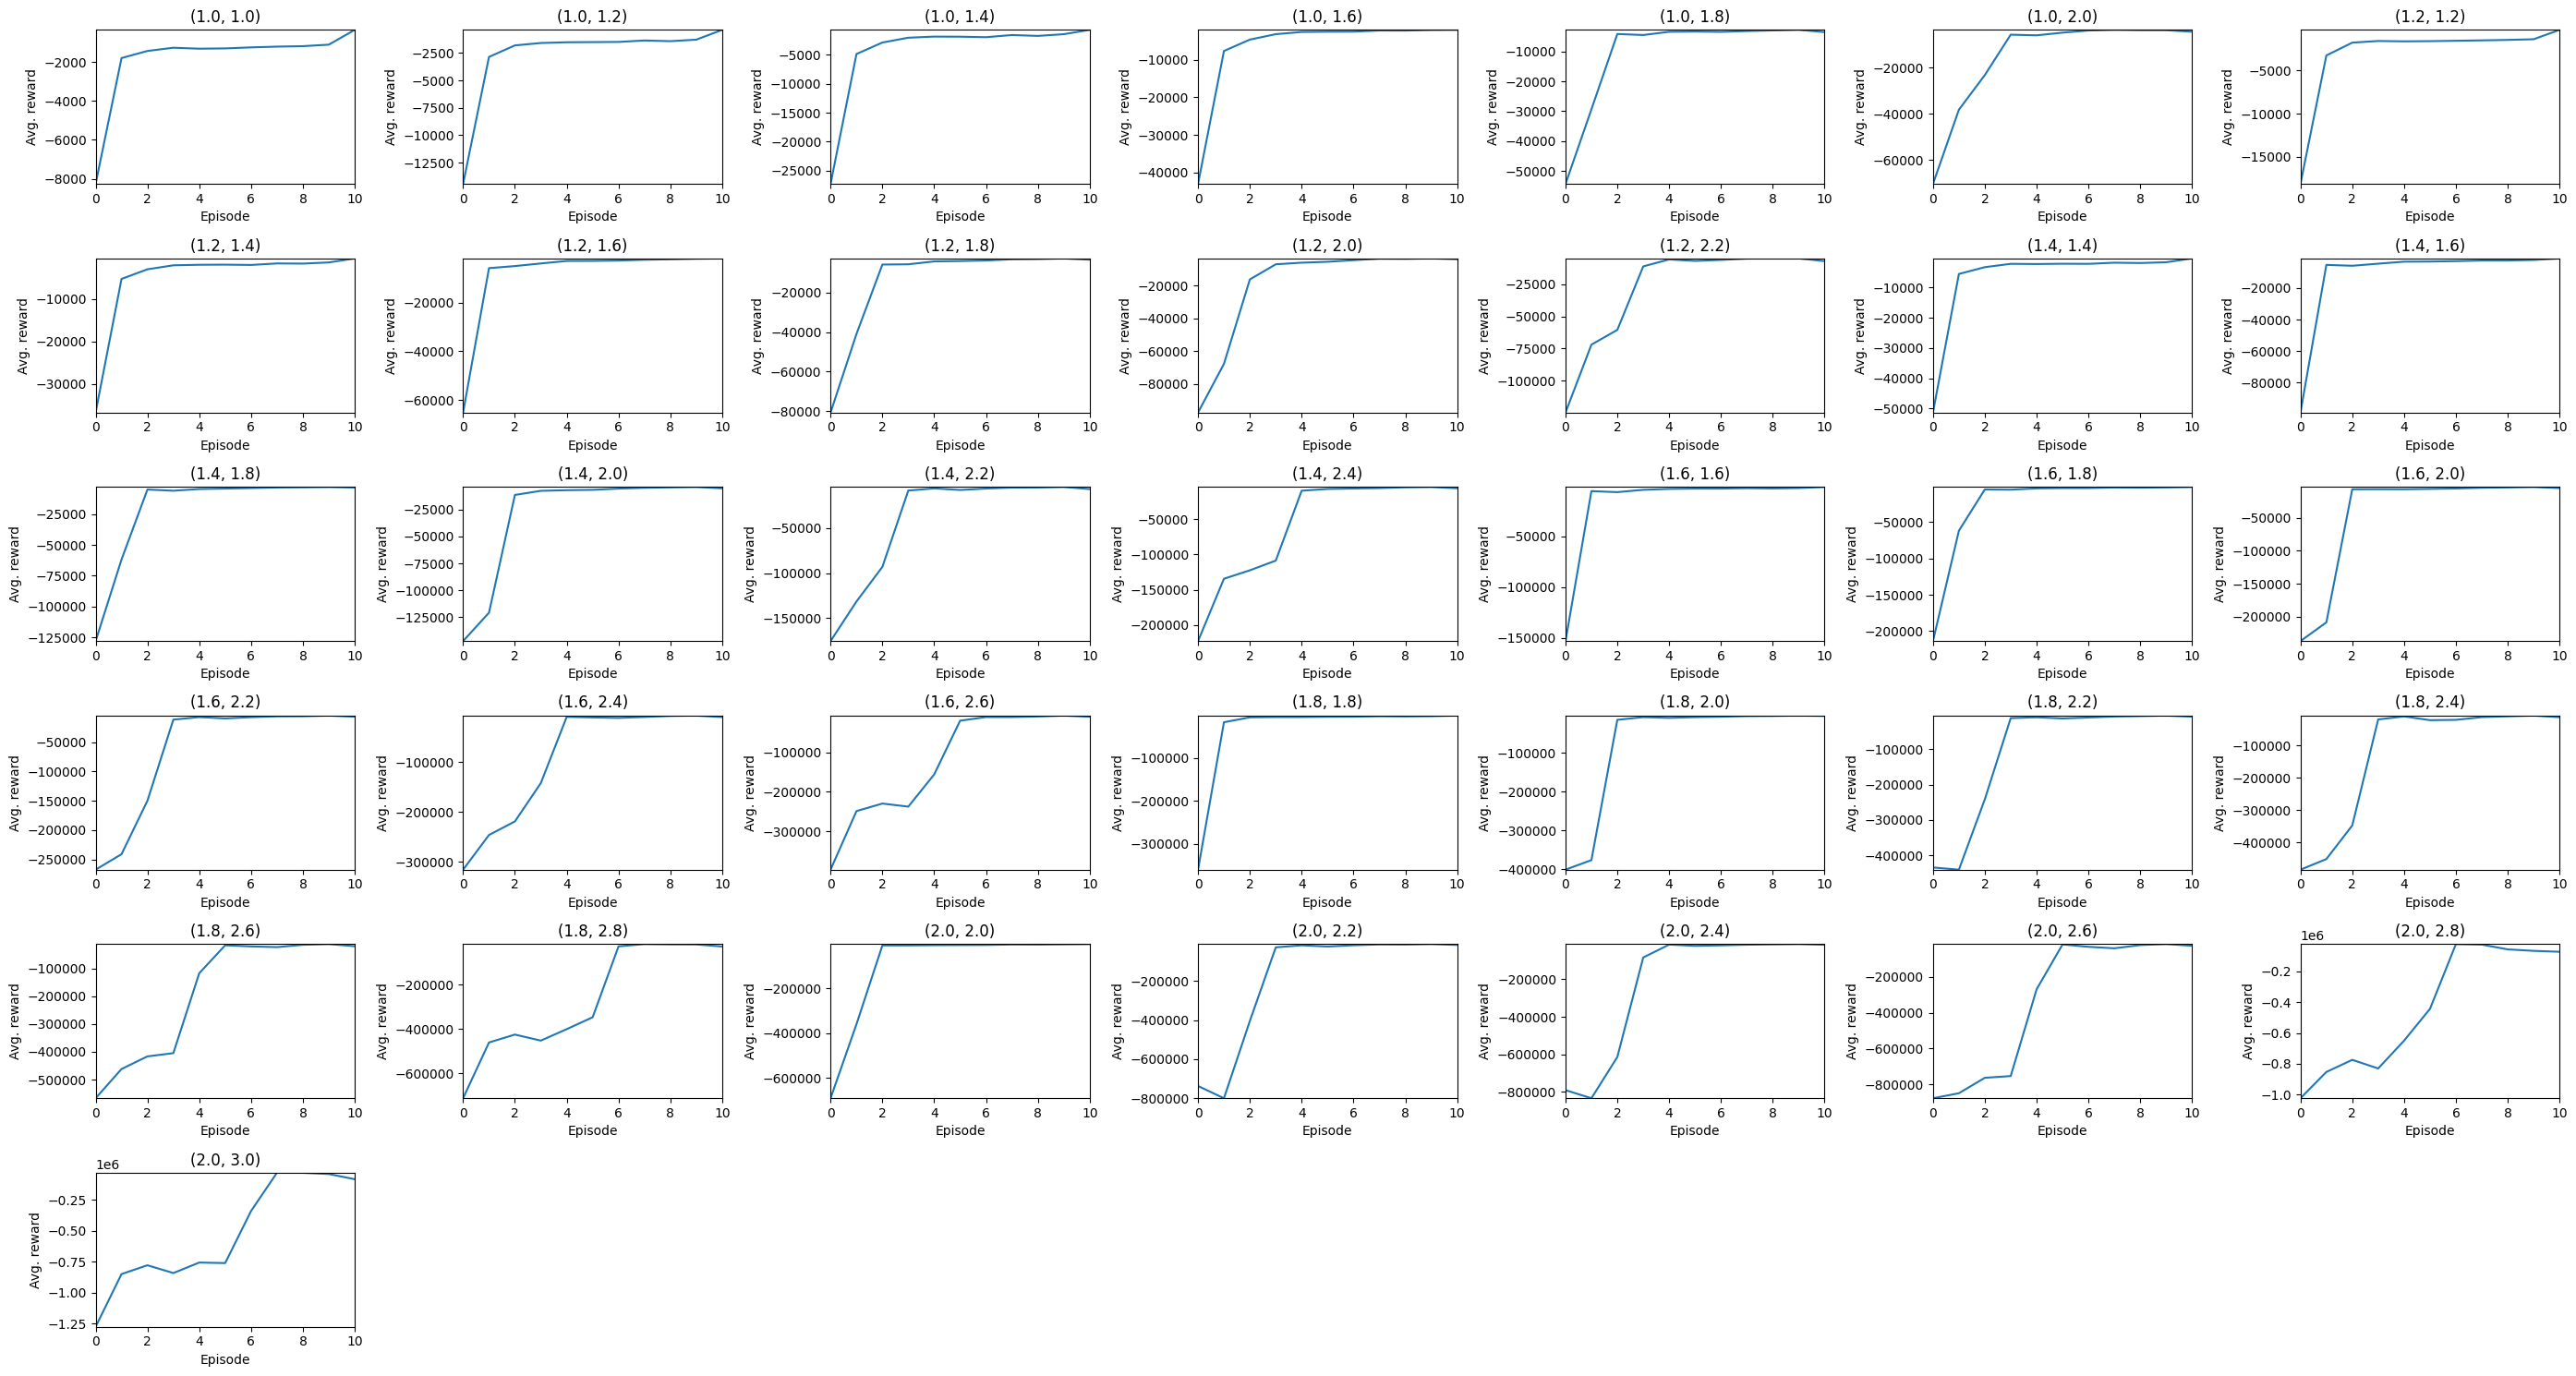

In [9]:
column_count_limit = 7
simulation_ids = reward_data['id'].unique()
row_count = math.ceil(len(simulation_ids)/column_count_limit)
column_count = min(len(simulation_ids), column_count_limit)
fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count, 2.5*row_count))

for ax in fig.axes[len(simulation_ids):]:
    fig.delaxes(ax)

for i, (ax, ((l, h), rdata)) in enumerate(zip(fig.axes, reward_data.groupby(['lower_exponent', 'higher_exponent']))):
    x = rdata['episode'].tolist()
    y = rdata['sum'].tolist()
    ax.plot(x, y)
    ax.set_title(f'({l}, {h})')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Avg. reward')
    ax.set_xticks(range(0, max(x) + 2, 2))
    ax.margins(0)
    
plt.tight_layout()
plt.show()